In [479]:
import pandas as pd
import numpy as nppip
import yaml
import os
import matplotlib.pyplot as plt

In [480]:
def read_yaml_files_to_dataframe(directory):
    rows_list = []
    for filename in sorted(os.listdir(directory)):
        if filename.endswith(".yaml"):
            file_path = os.path.join(directory, filename)
            file_number = filename.split('.')[0]

            with open(file_path, 'r') as file:
                content = yaml.safe_load(file)

                instance_data = content['problem']['instance']
                bottom_name = content['problem']['shape']['name']

                if len(bottom_name.split('_')) < 3:
                    group_name = bottom_name.split('_')[0]
                    layer_type = bottom_name.split('_')[1]
                    resid_block_num = None
                    mamba_block = None
                else:
                    group_name = bottom_name.split('_')[0]
                    resid_block_num = int(bottom_name.split('_')[1])
                    mamba_block = bottom_name.split('_')[2]
                    if len(bottom_name.split('_')) == 4:
                        layer_type = bottom_name.split('_')[3]
                    else:
                        layer_type = bottom_name.split('_')[3] + '_' + bottom_name.split('_')[4]

                row_data = {'File Number': file_number, 'Name': bottom_name, 'Group': group_name, 'Residual Block Number': resid_block_num, 'Mamba Block': mamba_block, 'Layer Type': layer_type}
                row_data.update(instance_data)
                rows_list.append(row_data)

    df = pd.DataFrame(rows_list)
    return df


def parse_stats(file_path):
    # Define the keys we want to extract from the stats section
    keys = [
        "GFLOPs (@1GHz)", "Utilization", "Cycles", "Energy", "EDP(J*cycle)", "Area",
        "mac", "psum_spad", "weights_spad", "ifmap_spad", "shared_glb", "DRAM", "Total"
    ]
    values = {}
    
    # Start reading file when "Summary Stats" is found
    with open(file_path, 'r') as file:
        record = False
        record_compute = False
        for line in file:
            if "Summary Stats" in line:
                record = True
            if "fJ/Compute" in line:
                record_compute = True
            if record:
                if ":" in line:
                    key, value = line.split(':')
                    key = key.strip()
                    value = value.strip().split()[0]  # Split to ignore units and take the first value
                    if key in keys:
                        values[key] = value
                if "Total" in line and line.startswith("    Total"):
                    record = False
            if record_compute:
                if "=" in line:  # Look for lines with '=' which denotes key-value pairs in fJ/Compute section
                    key, value = line.strip().split('=')
                    key = key.strip()
                    value = value.strip().split()[0]  # Strip and split to ignore spaces and units
                    values[key] = value
                if "Total" in line and line.startswith("    Total"):  # Stop recording after Total
                    break
    return values

def read_stats_from_directories(base_directory):
    rows_list = []

    # Iterate over subdirectories
    for subdir in sorted(os.listdir(base_directory)):
        dir_path = os.path.join(base_directory, subdir)
        if os.path.isdir(dir_path):
            stats_file = os.path.join(dir_path, 'timeloop-mapper.stats.txt')
            if os.path.exists(stats_file):
                # Parse the stats file
                stats = parse_stats(stats_file)
                # Add the file number (subdirectory name) to the row
                stats['Layer Number'] = subdir
                rows_list.append(stats)

    # Create DataFrame from list of rows
    df = pd.DataFrame(rows_list)
    return df

def create_merged_df(OUTPUT_DIRECTORY, BASE_FOLDER):
    merged_df = pd.merge(read_stats_from_directories(OUTPUT_DIRECTORY), read_yaml_files_to_dataframe(BASE_FOLDER), left_on='Layer Number', right_on='File Number', how='inner')
    merged_df = merged_df.drop(columns=['File Number'])
    return merged_df

def convert_to_floats(merged_df):
    #try converting every column to floats
    for column in merged_df.columns:
        try:
            merged_df[column] = merged_df[column].astype(float)
        except:
            print('failed to convert column to float', column)
            pass

    merged_df['Utilization'] = merged_df['Utilization'].str.rstrip('%').astype('float')
    merged_df.rename(columns={'Utilization': 'Utilization (%)'}, inplace=True)

    return merged_df

def plot_mamba_block(resid_block_df, NETWORK_NAME):
    #make a bar graph for these values where each bar is a different layer type nad the y axis is the energy used. show the breakdown by memory
    #convert fJ

    resid_block_df['DRAM'] = resid_block_df['DRAM'] / 1e3
    resid_block_df['shared_glb'] = resid_block_df['shared_glb'] / 1e3
    resid_block_df['ifmap_spad'] = resid_block_df['ifmap_spad'] / 1e3
    resid_block_df['weights_spad'] = resid_block_df['weights_spad'] / 1e3
    resid_block_df['psum_spad'] = resid_block_df['psum_spad'] / 1e3
    resid_block_df['mac'] = resid_block_df['mac'] / 1e3
    resid_block_df['Total Energy (fJ/compute)'] = resid_block_df['Total Energy (fJ/compute)'] / 1e3
    plt.figure()
    resid_block_df.plot(x='Layer Type', y=['DRAM', 'shared_glb', 'ifmap_spad', 'weights_spad', 'psum_spad', 'mac'], kind='bar', stacked=True, color=['blue', 'orange', 'green', 'red', 'purple', 'brown'])
    plt.xlabel('Layer Type')
    plt.ylabel('Energy Used (pJ / Cycle)')
    plt.title(f'Energy Used per Memory Type for {NETWORK_NAME}')
    plt.show()

def plot_total_energy(resid_block_df, NETWORK_NAME):
    #plot total energy in each layer tpye
    plt.figure()
    #add another y axis for number of cycles
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.bar(resid_block_df['Layer Type'], resid_block_df['Energy'], label=f'Energy', color='blue')
    ax2.scatter(resid_block_df['Layer Type'], resid_block_df['Cycles'] / 1e3, label=f'Cycles', color='orange')
    ax1.set_xlabel('Layer Type')
    ax1.set_ylabel('Total Energy (uJ)', color='blue')
    ax2.set_ylabel('Total Cycles (in thousands)', color='orange')
    plt.title(f'Total Energy and Cycles per Layer Type for {NETWORK_NAME}')
    plt.show()



In [481]:
NETWORK_NAME = 'mamba_370m'

BASE_FOLDER = f'/Users/andis/Documents/MIT/hardware_arch/6.5931-final-project/workspace/final-project/example_designs/layer_shapes/{NETWORK_NAME}'
OUTPUT_DIRECTORY = f'/Users/andis/Documents/MIT/hardware_arch/6.5931-final-project/workspace/final-project/example_designs/example_designs/eyeriss_like/outputs/{NETWORK_NAME}'

merged_df = create_merged_df(OUTPUT_DIRECTORY, BASE_FOLDER)


#save df to file
merged_df.to_csv(f'{NETWORK_NAME}_stats.csv', index=False)

merged_df = convert_to_floats(merged_df)
mamba_370m_df = merged_df.copy()

resid_block_df = merged_df[merged_df['Residual Block Number'] == 0]
resid_block_df['Total Energy (fJ/compute)'] = resid_block_df['DRAM'] + resid_block_df['shared_glb'] + resid_block_df['ifmap_spad'] + resid_block_df['weights_spad'] + resid_block_df['psum_spad'] + resid_block_df['mac']

plot_mamba_block(resid_block_df, NETWORK_NAME)

plot_total_energy(resid_block_df, NETWORK_NAME)
total_energy = merged_df['Energy'].sum()
print(total_energy)

IndexError: list index out of range

failed to convert column to float Utilization
failed to convert column to float Name
failed to convert column to float Group
failed to convert column to float Mamba Block
failed to convert column to float Layer Type


/var/folders/bh/w_lx1mqd7h55ht6qy7mc2yh80000gn/T/ipykernel_34979/167107226.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resid_block_df['Total Energy (fJ/compute)'] = resid_block_df['DRAM'] + resid_block_df['shared_glb'] + resid_block_df['ifmap_spad'] + resid_block_df['weights_spad'] + resid_block_df['psum_spad'] + resid_block_df['mac']
/var/folders/bh/w_lx1mqd7h55ht6qy7mc2yh80000gn/T/ipykernel_34979/2230961755.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resid_block_df['DRAM'] = resid_block

<Figure size 640x480 with 0 Axes>

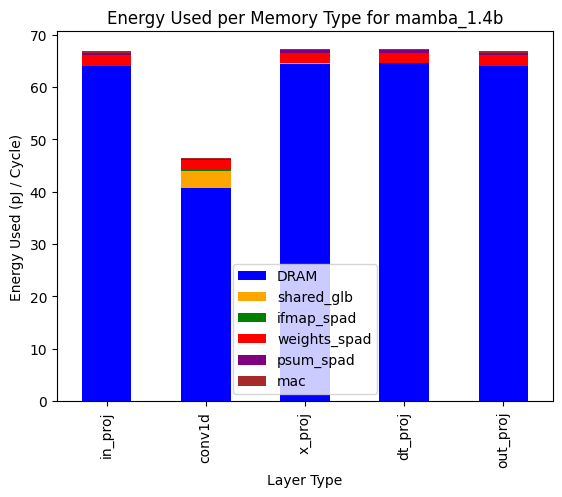

<Figure size 640x480 with 0 Axes>

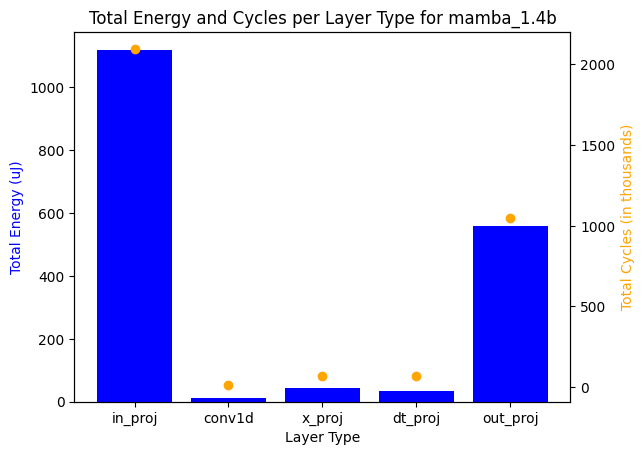

91827.10999999999


In [ ]:
NETWORK_NAME = 'mamba_1.4b'

BASE_FOLDER = f'/Users/andis/Documents/MIT/hardware_arch/6.5931-final-project/workspace/final-project/example_designs/layer_shapes/{NETWORK_NAME}'
OUTPUT_DIRECTORY = f'/Users/andis/Documents/MIT/hardware_arch/6.5931-final-project/workspace/final-project/example_designs/example_designs/eyeriss_like/outputs/{NETWORK_NAME}'

merged_df = create_merged_df(OUTPUT_DIRECTORY, BASE_FOLDER)

#save df to file
merged_df.to_csv(f'{NETWORK_NAME}_stats.csv', index=False)

merged_df = convert_to_floats(merged_df)
mamba_14b_df = merged_df.copy()

resid_block_df = merged_df[merged_df['Residual Block Number'] == 0]
resid_block_df['Total Energy (fJ/compute)'] = resid_block_df['DRAM'] + resid_block_df['shared_glb'] + resid_block_df['ifmap_spad'] + resid_block_df['weights_spad'] + resid_block_df['psum_spad'] + resid_block_df['mac']

plot_mamba_block(resid_block_df, NETWORK_NAME)

plot_total_energy(resid_block_df, NETWORK_NAME)
total_energy = merged_df['Energy'].sum()
print(total_energy)

In [ ]:
m_370 = mamba_370m_df[mamba_370m_df['Residual Block Number'] == 0]
m_14 = mamba_14b_df[mamba_14b_df['Residual Block Number'] == 0]

<BarContainer object of 5 artists>

<Figure size 640x480 with 0 Axes>

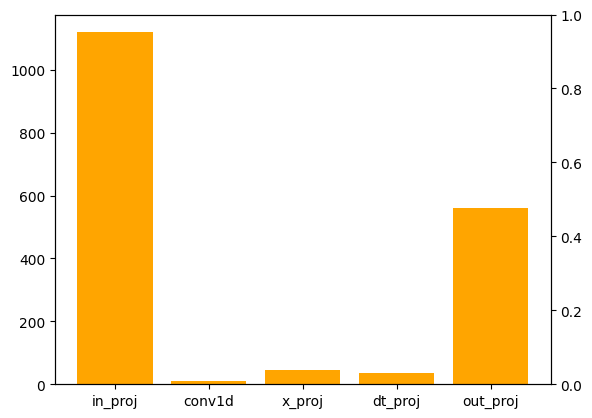

In [ ]:
#bar graph of Energy
plt.figure()
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.bar(m_370['Layer Type'], m_370['Energy'], label=f'Energy 370m', color='blue')
#side by side bars
ax1.bar(m_14['Layer Type'], m_14['Energy'], label=f'Energy 1.4b', color='orange')

In [ ]:
m_14

,GFLOPs (@1GHz),Utilization (%),Cycles,Energy,EDP(J*cycle),Area,mac,psum_spad,weights_spad,ifmap_spad,...,Mamba Block,Layer Type,C,G,M,N,P,Q,R,S
0,16.00,4.76,2097152.0,1120.29,2350.000,0.0,207.69,470.41,1930.72,106.84,...,mixer,in_proj,2048.0,1.0,8192.0,1.0,1.0,1.0,1.0,1.0
1,28.00,9.52,13312.0,9.89,0.132,0.0,207.69,219.54,1934.30,189.91,...,mixer,conv1d,1.0,4096.0,1.0,1.0,1.0,13.0,1.0,4.0
2,20.00,5.95,65536.0,44.04,2.890,0.0,207.69,470.52,1930.72,112.37,...,mixer,x_proj,4096.0,1.0,160.0,1.0,1.0,1.0,1.0,1.0
3,15.94,4.76,65536.0,35.25,2.310,0.0,207.69,454.83,1930.72,101.34,...,mixer,dt_proj,128.0,1.0,4096.0,1.0,1.0,1.0,1.0,1.0
4,16.00,4.76,1048576.0,560.21,587.000,0.0,207.69,470.47,1930.72,106.84,...,mixer,out_proj,4096.0,1.0,2048.0,1.0,1.0,1.0,1.0,1.0


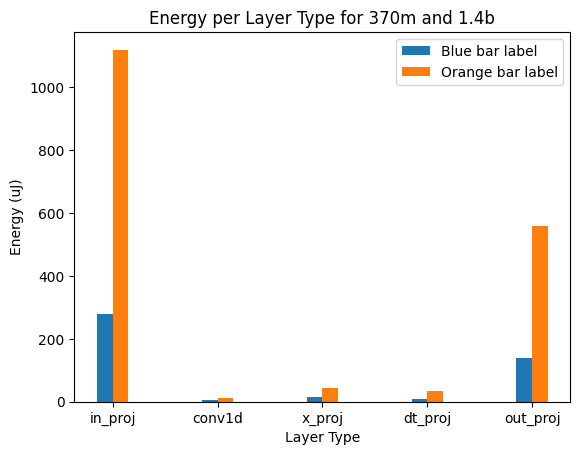

In [ ]:
import numpy as np
# Numbers of pairs of bars you want
N = 5

# Data on X-axis

# Specify the values of blue bars (height)
blue_bar = m_370['Energy']
orange_bar = m_14['Energy']
# Specify the values of orange bars (height)

# Position of bars on x-axis
ind = np.arange(N)

# Width of a bar 
width = 0.15       

# Plotting
plt.bar(ind, blue_bar , width, label='Blue bar label')
plt.bar(ind + width, orange_bar, width, label='Orange bar label')


plt.xlabel('Layer Type')
plt.ylabel('Energy (uJ)')
plt.title('Energy per Layer Type for 370m and 1.4b')

# xticks()
# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations
#ticks should be layter names
plt.xticks(ind + width / 2, m_370['Layer Type'])

# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.show()


In [ ]:
pd.concat([m_370['Energy'], m_14['Energy']], axis=1)
new_table = pd.concat([m_370['Layer Type'], m_370['Energy'], m_14['Energy']], axis=1)
new_table.columns = ['Layer Type', '370m', '1.4b']
#round to 2 decimal places
new_table['Multiplier'] = new_table['1.4b'] / new_table['370m']
new_table['Multiplier'] = new_table['Multiplier'].round(2)

In [ ]:
new_table.set_index('Layer Type')
#add a row label for the top called energy
new_table.loc['Energy'] = ['uJ', m_370['Energy'].sum(), m_14['Energy'].sum(), new_table['Multiplier'].mean()]

In [ ]:
new_table

,Layer Type,370m,1.4b,Multiplier
0,in_proj,280.24,1120.29,4.000
1,conv1d,4.94,9.89,2.000
2,x_proj,13.27,44.04,3.320
3,dt_proj,8.88,35.25,3.970
4,out_proj,140.16,560.21,4.000
Energy,uJ,447.49,1769.68,3.458


In [ ]:
m_370['Total Energy per Cycle']

,GFLOPs (@1GHz),Utilization (%),Cycles,Energy,EDP(J*cycle),Area,mac,psum_spad,weights_spad,ifmap_spad,...,Mamba Block,Layer Type,C,G,M,N,P,Q,R,S
0,15.99,4.76,524288.0,280.24,147.0000,0.0,207.69,470.29,1930.72,106.84,...,mixer,in_proj,1024.0,1.0,4096.0,1.0,1.0,1.0,1.0,1.0
1,28.00,9.52,6656.0,4.94,0.0329,0.0,207.69,219.54,1934.30,189.91,...,mixer,conv1d,1.0,2048.0,1.0,1.0,1.0,13.0,1.0,4.0
2,23.99,7.14,16384.0,13.27,0.2170,0.0,207.69,470.41,1930.72,123.41,...,mixer,x_proj,2048.0,1.0,96.0,1.0,1.0,1.0,1.0,1.0
3,15.88,4.76,16384.0,8.88,0.1450,0.0,207.69,439.12,1930.72,101.37,...,mixer,dt_proj,64.0,1.0,2048.0,1.0,1.0,1.0,1.0,1.0
4,16.00,4.76,262144.0,140.16,36.7000,0.0,207.69,470.52,1930.72,106.84,...,mixer,out_proj,2048.0,1.0,1024.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
#pi chart for conv layer of energy epr cycle
plt.figure()
m_370[m_370['Layer Type'] == 'conv1d']['mac', 'ifmap_spad', 'weights_spad', 'psum_spad', 'shared_glb', 'DRAM']

KeyError: ('mac', 'ifmap_spad', 'weights_spad', 'psum_spad', 'shared_glb', 'DRAM')

<Figure size 640x480 with 0 Axes>

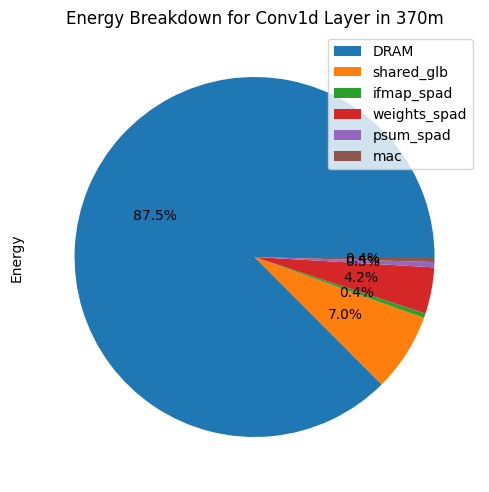

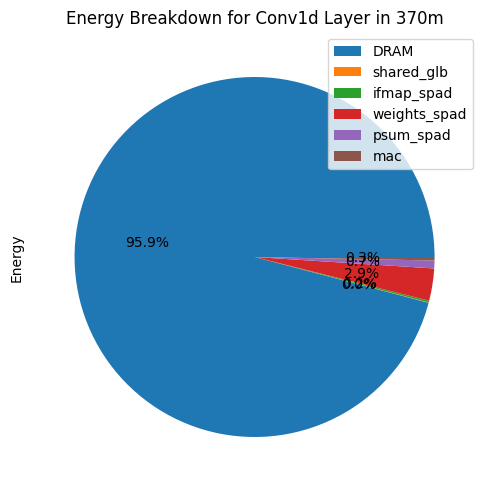

In [ ]:
#one figure


conv_breakdown = m_370[m_370['Layer Type'] == 'conv1d']
conv_breakdown = conv_breakdown[['DRAM', 'shared_glb', 'ifmap_spad', 'weights_spad', 'psum_spad', 'mac']]
#pi chart
conv_breakdown = conv_breakdown.T
conv_breakdown.columns = ['Energy']
#no labels on pie chart
conv_breakdown.plot.pie(y='Energy',labels=None, autopct='%1.1f%%')
#percentages and labels on chart overlap, make it not overlap
plt.tight_layout()
plt.title('Energy Breakdown for Conv1d Layer in 370m')


conv_breakdown = m_370[m_370['Layer Type'] == 'in_proj']
conv_breakdown = conv_breakdown[['DRAM', 'shared_glb', 'ifmap_spad', 'weights_spad', 'psum_spad', 'mac']]
#pi chart
conv_breakdown = conv_breakdown.T
conv_breakdown.columns = ['Energy']
#no labels on pie chart
conv_breakdown.plot.pie(y='Energy',labels=None, autopct='%1.1f%%')
#percentages and labels on chart overlap, make it not overlap
plt.tight_layout()
plt.title('Energy Breakdown for Conv1d Layer in 370m')
plt.show()

In [482]:
NETWORK_NAME = 'gpt2'

BASE_FOLDER = f'/Users/andis/Documents/MIT/hardware_arch/6.5931-final-project/workspace/final-project/example_designs/layer_shapes/{NETWORK_NAME}'
OUTPUT_DIRECTORY = f'/Users/andis/Documents/MIT/hardware_arch/6.5931-final-project/workspace/final-project/example_designs/example_designs/eyeriss_like/outputs/{NETWORK_NAME}'

def read_stats_from_directories(base_directory):
    rows_list = []

    # Iterate over subdirectories
    for subdir in sorted(os.listdir(base_directory)):
        dir_path = os.path.join(base_directory, subdir)
        if os.path.isdir(dir_path):
            stats_file = os.path.join(dir_path, 'timeloop-mapper.stats.txt')
            if os.path.exists(stats_file):
                # Parse the stats file
                stats = parse_stats(stats_file)
                # Add the file number (subdirectory name) to the row
                stats['Layer Number'] = subdir
                rows_list.append(stats)

    # Create DataFrame from list of rows
    df = pd.DataFrame(rows_list)
    return df


# #save df to file
# merged_df.to_csv(f'{NETWORK_NAME}_stats.csv', index=False)

# merged_df = convert_to_floats(merged_df)
# mamba_370m_df = merged_df.copy()

# resid_block_df = merged_df[merged_df['Residual Block Number'] == 0]
# resid_block_df['Total Energy (fJ/compute)'] = resid_block_df['DRAM'] + resid_block_df['shared_glb'] + resid_block_df['ifmap_spad'] + resid_block_df['weights_spad'] + resid_block_df['psum_spad'] + resid_block_df['mac']

# plot_mamba_block(resid_block_df, NETWORK_NAME)

# plot_total_energy(resid_block_df, NETWORK_NAME)
# total_energy = merged_df['Energy'].sum()
# print(total_energy)

In [483]:
gpt2_df = read_stats_from_directories(OUTPUT_DIRECTORY)
gpt2_df = convert_to_floats(gpt2_df)


failed to convert column to float Utilization


In [484]:
gpt2_one_block = gpt2_df[gpt2_df['Layer Number'] <= 5]
gpt2_one_block

,GFLOPs (@1GHz),Utilization (%),Cycles,Energy,EDP(J*cycle),Area,mac,psum_spad,weights_spad,ifmap_spad,shared_glb,DRAM,Total,Layer Number
0,23.99,7.14,67108864.0,2897.96,194000.0000,0.0,207.69,483.31,993.57,189.68,515.99,1208.33,3598.57,0.0
1,15.99,4.76,33554432.0,988.47,33200.0000,0.0,207.69,524.85,997.24,106.84,1033.20,812.50,3682.33,1.0
2,15.97,4.76,32768.0,1.98,0.0649,0.0,207.69,490.57,1048.69,123.41,429.82,5250.00,7550.19,2.0
3,15.97,4.76,131072.0,7.12,0.9330,0.0,207.69,510.61,1048.69,112.37,409.11,4500.00,6788.47,3.0
4,15.99,4.76,134217728.0,3274.80,440000.0000,0.0,207.69,483.77,993.57,145.50,406.87,812.50,3049.90,4.0
5,16.00,4.76,134217728.0,3395.72,456000.0000,0.0,207.69,524.85,997.24,123.41,543.69,765.62,3162.51,5.0


Text(0.5, 1.0, 'Energy/Cycle per Memory Type for 1 Transformer Block in gpt2')

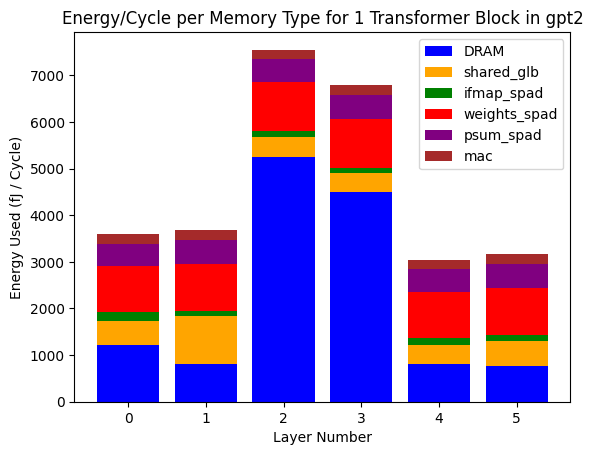

In [485]:
plt.figure()
#stacked bar graph
plt.bar(gpt2_one_block['Layer Number'], gpt2_one_block['DRAM'], label='DRAM', color='blue')
plt.bar(gpt2_one_block['Layer Number'], gpt2_one_block['shared_glb'], label='shared_glb', color='orange', bottom = gpt2_one_block['DRAM'])
plt.bar(gpt2_one_block['Layer Number'], gpt2_one_block['ifmap_spad'], label='ifmap_spad', color='green', bottom = gpt2_one_block['DRAM'] + gpt2_one_block['shared_glb'])
plt.bar(gpt2_one_block['Layer Number'], gpt2_one_block['weights_spad'], label='weights_spad', color='red', bottom = gpt2_one_block['DRAM'] + gpt2_one_block['shared_glb'] + gpt2_one_block['ifmap_spad'])
plt.bar(gpt2_one_block['Layer Number'], gpt2_one_block['psum_spad'], label='psum_spad', color='purple', bottom = gpt2_one_block['DRAM'] + gpt2_one_block['shared_glb'] + gpt2_one_block['ifmap_spad'] + gpt2_one_block['weights_spad'])
plt.bar(gpt2_one_block['Layer Number'], gpt2_one_block['mac'], label='mac', color='brown', bottom = gpt2_one_block['DRAM'] + gpt2_one_block['shared_glb'] + gpt2_one_block['ifmap_spad'] + gpt2_one_block['weights_spad'] + gpt2_one_block['psum_spad'])
plt.legend()
plt.xlabel('Layer Number')
plt.ylabel('Energy Used (fJ / Cycle)')
plt.title(f'Energy/Cycle per Memory Type for 1 Transformer Block in {NETWORK_NAME}')

<Figure size 640x480 with 0 Axes>

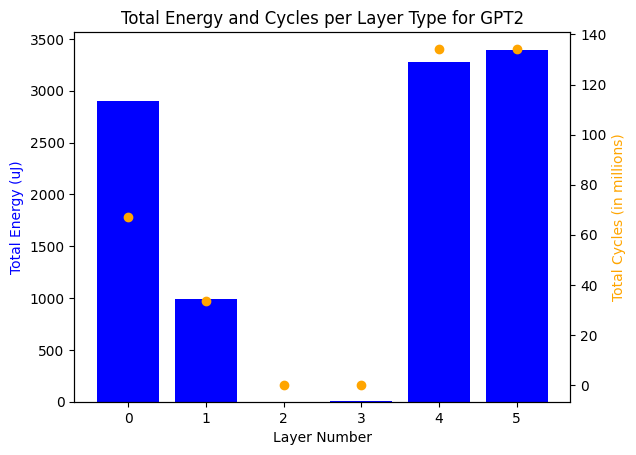

In [486]:
plt.figure()
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.bar(gpt2_one_block['Layer Number'], gpt2_one_block['Energy'], label='Energy', color='blue')
ax2.scatter(gpt2_one_block['Layer Number'], gpt2_one_block['Cycles'] / 1e6, label='Cycles', color='orange')
ax1.set_xlabel('Layer Number')
ax1.set_ylabel('Total Energy (uJ)', color='blue')
ax2.set_ylabel('Total Cycles (in millions)', color='orange')
plt.title(f'Total Energy and Cycles per Layer Type for GPT2')
plt.show()

In [487]:
NETWORK_NAME = 'mamba_370M'

BASE_FOLDER = f'/Users/andis/Documents/MIT/hardware_arch/6.5931-final-project/workspace/final-project/example_designs/layer_shapes/{NETWORK_NAME}'
OUTPUT_DIRECTORY = f'/Users/andis/Documents/MIT/hardware_arch/6.5931-final-project/workspace/final-project/example_designs/example_designs/eyeriss_like/outputs/{NETWORK_NAME}'

merged_df = create_merged_df(OUTPUT_DIRECTORY, BASE_FOLDER)

merged_df = convert_to_floats(merged_df)

IndexError: list index out of range

In [ ]:
mamba_block = merged_df[merged_df['Residual Block Number'] == 0]
mamba_block

,GFLOPs (@1GHz),Utilization (%),Cycles,Energy,EDP(J*cycle),Area,mac,psum_spad,weights_spad,ifmap_spad,...,Mamba Block,Layer Type,C,G,M,N,P,Q,R,S
0,15.99,4.76,524288.0,280.24,147.0000,0.0,207.69,470.29,1930.72,106.84,...,mixer,in_proj,1024.0,1.0,4096.0,1.0,1.0,1.0,1.0,1.0
1,28.00,9.52,6656.0,4.94,0.0329,0.0,207.69,219.54,1934.30,189.91,...,mixer,conv1d,1.0,2048.0,1.0,1.0,1.0,13.0,1.0,4.0
2,23.99,7.14,16384.0,13.27,0.2170,0.0,207.69,470.41,1930.72,123.41,...,mixer,x_proj,2048.0,1.0,96.0,1.0,1.0,1.0,1.0,1.0
3,15.88,4.76,16384.0,8.88,0.1450,0.0,207.69,439.12,1930.72,101.37,...,mixer,dt_proj,64.0,1.0,2048.0,1.0,1.0,1.0,1.0,1.0
4,16.00,4.76,262144.0,140.16,36.7000,0.0,207.69,470.52,1930.72,106.84,...,mixer,out_proj,2048.0,1.0,1024.0,1.0,1.0,1.0,1.0,1.0


Text(0.5, 1.0, 'Energy/Cycle per Memory Type for 1 Transformer Block in mamba_370M')

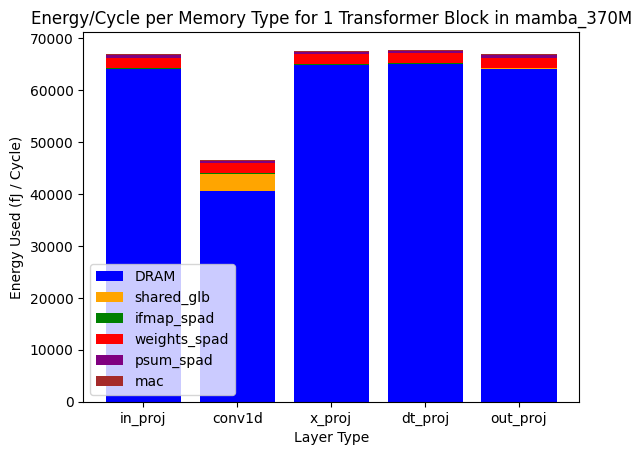

In [ ]:
#bar graph of Energy
plt.figure()
plt.bar(mamba_block['Layer Type'], mamba_block['DRAM'], label=f'DRAM', color='blue')
plt.bar(mamba_block['Layer Type'], mamba_block['shared_glb'], label=f'shared_glb', color='orange', bottom=mamba_block['DRAM'])
plt.bar(mamba_block['Layer Type'], mamba_block['ifmap_spad'], label=f'ifmap_spad', color='green', bottom=mamba_block['DRAM'] + mamba_block['shared_glb'])
plt.bar(mamba_block['Layer Type'], mamba_block['weights_spad'], label=f'weights_spad', color='red', bottom=mamba_block['DRAM'] + mamba_block['shared_glb'] + mamba_block['ifmap_spad'])
plt.bar(mamba_block['Layer Type'], mamba_block['psum_spad'], label=f'psum_spad', color='purple', bottom=mamba_block['DRAM'] + mamba_block['shared_glb'] + mamba_block['ifmap_spad'] + mamba_block['weights_spad'])
plt.bar(mamba_block['Layer Type'], mamba_block['mac'], label=f'mac', color='brown', bottom=mamba_block['DRAM'] + mamba_block['shared_glb'] + mamba_block['ifmap_spad'] + mamba_block['weights_spad'] + mamba_block['psum_spad'])
plt.legend()
plt.xlabel('Layer Type')
plt.ylabel('Energy Used (fJ / Cycle)')
plt.title(f'Energy/Cycle per Memory Type for 1 Transformer Block in {NETWORK_NAME}')



<Figure size 640x480 with 0 Axes>

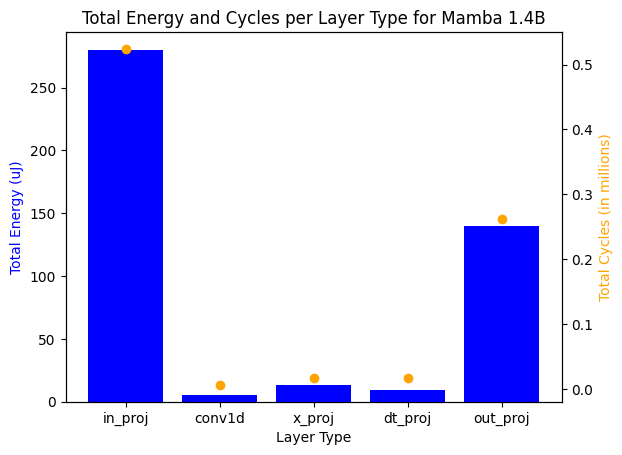

In [ ]:
plt.figure()
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.bar(mamba_block['Layer Type'], mamba_block['Energy'], label='Energy', color='blue')
ax2.scatter(mamba_block['Layer Type'], mamba_block['Cycles'] / 1e6, label='Cycles', color='orange')
ax1.set_xlabel('Layer Type')
ax1.set_ylabel('Total Energy (uJ)', color='blue')
ax2.set_ylabel('Total Cycles (in millions)', color='orange')
plt.title(f'Total Energy and Cycles per Layer Type for Mamba 1.4B')
plt.show()

In [ ]:
new_table = pd.concat([mamba_block['Energy'], gpt2_one_block['Energy']], axis=1)
new_table.columns = ['Energy (uJ) Mamba 370M', 'Energy (uJ) GPT2 (345M)']
new_table.index = gpt2_one_block['Layer Number']
#add total
new_table.loc['Total Energy(uJ)'] = [mamba_block['Energy'].sum(), gpt2_one_block['Energy'].sum()]
#


In [ ]:
new_table

,Energy (uJ) Mamba 370M,Energy (uJ) GPT2 (345M)
Layer Number,,
0.0,280.24,2897.96
1.0,4.94,988.47
2.0,13.27,1.98
3.0,8.88,7.12
4.0,140.16,3274.80
5.0,NaN,3395.72
Total Energy(uJ),447.49,10566.05


<BarContainer object of 241 artists>

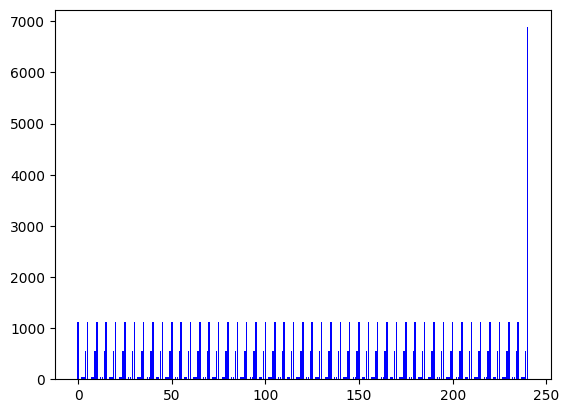

In [ ]:
plt.bar(mamba_14b_df['Layer Number'], mamba_14b_df['Energy'], label='1.4b', color='blue')

In [ ]:
gpt2_df['Energy'][:-1].sum()

253585.19999999995

In [ ]:
gpt2_df['Energy'].sum()

337190.42999999993

In [ ]:
mamba_14b_df['Energy'][:-1].sum()

84944.63999999998

In [ ]:
mamba_14b_df['Energy'].sum()

91827.10999999999

IndexError: list index out of range

In [ ]:
parse_stats('/Users/andis/Documents/MIT/hardware_arch/6.5931-final-project/workspace/final-project/example_designs/example_designs/eyeriss_like/outputs/mamba_370m')

IsADirectoryError: [Errno 21] Is a directory: '/Users/andis/Documents/MIT/hardware_arch/6.5931-final-project/workspace/final-project/example_designs/example_designs/eyeriss_like/outputs/mamba_370m'

In [ ]:
mamba_370 = read_stats_from_directories('/Users/andis/Documents/MIT/hardware_arch/6.5931-final-project/workspace/final-project/example_designs/example_designs/eyeriss_like/outputs/mamba_370m')



In [ ]:
mamba_370['Energy'] = mamba_370['Energy'].astype(float)

In [ ]:
mamba_370['Energy'].sum()

41825.1

In [ ]:
mamba_370.head(20)

,GFLOPs (@1GHz),Utilization,Cycles,Energy,EDP(J*cycle),Area,mac,psum_spad,weights_spad,ifmap_spad,shared_glb,DRAM,Total,Layer Number
0,15.99,4.76%,524288,280.24,1.47e+02,0.00,207.69,470.29,1930.72,106.84,20.62,64078.12,66814.29,000
1,28.00,9.52%,6656,4.94,3.29e-02,0.00,207.69,219.54,1934.30,189.91,3258.91,40615.38,46425.73,001
2,23.99,7.14%,16384,13.27,2.17e-01,0.00,207.69,470.41,1930.72,123.41,67.10,64697.92,67497.25,002
3,15.88,4.76%,16384,8.88,1.45e-01,0.00,207.69,439.12,1930.72,101.37,30.29,65031.25,67740.44,003
4,127.97,38.10%,512,2.33,1.19e-03,0.00,207.69,470.04,1930.72,189.68,253.46,68031.25,71082.85,004
5,16.00,4.76%,262144,140.16,3.67e+01,0.00,207.69,470.52,1930.72,106.84,23.03,64093.75,66832.55,005
6,15.99,4.76%,524288,280.24,1.47e+02,0.00,207.69,470.29,1930.72,106.84,20.62,64078.12,66814.29,006
7,28.00,9.52%,6656,4.94,3.29e-02,0.00,207.69,219.54,1934.30,189.91,3258.91,40615.38,46425.73,007
8,23.99,7.14%,16384,13.27,2.17e-01,0.00,207.69,470.41,1930.72,123.41,67.10,64697.92,67497.25,008
9,15.88,4.76%,16384,8.88,1.45e-01,0.00,207.69,439.12,1930.72,101.37,30.29,65031.25,67740.44,009


In [ ]:
def read_yaml_files_to_dataframe(directory):
    rows_list = []
    for filename in sorted(os.listdir(directory)):
        if filename.endswith(".yaml"):
            file_path = os.path.join(directory, filename)
            file_number = filename.split('.')[0]

            with open(file_path, 'r') as file:
                content = yaml.safe_load(file)

                instance_data = content['problem']['instance']
                bottom_name = content['problem']['shape']['name']

                if len(bottom_name.split('_')) < 3:
                    try:
                        group_name = bottom_name.split('_')[0]
                        layer_type = bottom_name.split('_')[1]
                        resid_block_num = None
                        mamba_block = None
                    except:
                        group_name = None
                        layer_type = bottom_name
                        resid_block_num = None
                        mamba_block = None
                else:
                    group_name = bottom_name.split('_')[0]
                    resid_block_num = int(bottom_name.split('_')[1])
                    mamba_block = bottom_name.split('_')[2]
                    if len(bottom_name.split('_')) == 4:
                        layer_type = bottom_name.split('_')[3]
                    else:
                        layer_type = bottom_name.split('_')[3] + '_' + bottom_name.split('_')[4]

                row_data = {'File Number': file_number, 'Name': bottom_name, 'Group': group_name, 'Residual Block Number': resid_block_num, 'Mamba Block': mamba_block, 'Layer Type': layer_type}
                row_data.update(instance_data)
                rows_list.append(row_data)

    df = pd.DataFrame(rows_list)
    return df


def parse_stats(file_path):
    # Define the keys we want to extract from the stats section
    keys = [
        "GFLOPs (@1GHz)", "Utilization", "Cycles", "Energy", "EDP(J*cycle)", "Area",
        "mac", "psum_spad", "weights_spad", "ifmap_spad", "shared_glb", "DRAM", "Total"
    ]
    values = {}
    
    # Start reading file when "Summary Stats" is found
    with open(file_path, 'r') as file:
        record = False
        record_compute = False
        for line in file:
            if "Summary Stats" in line:
                record = True
            if "fJ/Compute" in line:
                record_compute = True
            if record:
                if ":" in line:
                    key, value = line.split(':')
                    key = key.strip()
                    value = value.strip().split()[0]  # Split to ignore units and take the first value
                    if key in keys:
                        values[key] = value
                if "Total" in line and line.startswith("    Total"):
                    record = False
            if record_compute:
                if "=" in line:  # Look for lines with '=' which denotes key-value pairs in fJ/Compute section
                    key, value = line.strip().split('=')
                    key = key.strip()
                    value = value.strip().split()[0]  # Strip and split to ignore spaces and units
                    values[key] = value
                if "Total" in line and line.startswith("    Total"):  # Stop recording after Total
                    break
    return values

def read_stats_from_directories(base_directory):
    rows_list = []

    # Iterate over subdirectories
    for subdir in sorted(os.listdir(base_directory)):
        dir_path = os.path.join(base_directory, subdir)
        if os.path.isdir(dir_path):
            stats_file = os.path.join(dir_path, 'timeloop-mapper.stats.txt')
            if os.path.exists(stats_file):
                # Parse the stats file
                stats = parse_stats(stats_file)
                # Add the file number (subdirectory name) to the row
                stats['Layer Number'] = subdir
                rows_list.append(stats)

    # Create DataFrame from list of rows
    df = pd.DataFrame(rows_list)
    return df

def create_merged_df(OUTPUT_DIRECTORY, BASE_FOLDER):
    merged_df = pd.merge(read_stats_from_directories(OUTPUT_DIRECTORY), read_yaml_files_to_dataframe(BASE_FOLDER), left_on='Layer Number', right_on='File Number', how='inner')
    merged_df = merged_df.drop(columns=['File Number'])
    return merged_df

def convert_to_floats(merged_df):
    #try converting every column to floats
    for column in merged_df.columns:
        try:
            merged_df[column] = merged_df[column].astype(float)
        except:
            print('failed to convert column to float', column)
            pass

    merged_df['Utilization'] = merged_df['Utilization'].str.rstrip('%').astype('float')
    merged_df.rename(columns={'Utilization': 'Utilization (%)'}, inplace=True)

    return merged_df


In [ ]:
create_merged_df('/Users/andis/Documents/MIT/hardware_arch/6.5931-final-project/workspace/final-project/example_designs/example_designs/eyeriss_like/outputs/mamba_370m', '/Users/andis/Documents/MIT/hardware_arch/6.5931-final-project/workspace/final-project/example_designs/layer_shapes/mamba_370m')['Layer Type']

0       in_proj
1        conv1d
2        x_proj
3       dt_proj
4        matmul
         ...   
716         477
717         478
718         479
719    out_proj
720        head
Name: Layer Type, Length: 721, dtype: object

In [473]:
gpt2_df = read_stats_from_directories(OUTPUT_DIRECTORY)
gpt2_df = convert_to_floats(gpt2_df)
gpt2_block = gpt2_df[gpt2_df['Layer Number'] <= 5]

failed to convert column to float Utilization


In [478]:
gpt2_df

,GFLOPs (@1GHz),Utilization (%),Cycles,Energy,EDP(J*cycle),Area,mac,psum_spad,weights_spad,ifmap_spad,shared_glb,DRAM,Total,Layer Number
0,15.99,4.76,524288.0,280.24,147.00000,0.0,207.69,470.29,1930.72,106.84,20.62,64078.12,66814.29,0.0
1,28.00,9.52,6656.0,4.94,0.03290,0.0,207.69,219.54,1934.30,189.91,3258.91,40615.38,46425.73,1.0
2,23.99,7.14,16384.0,13.27,0.21700,0.0,207.69,470.41,1930.72,123.41,67.10,64697.92,67497.25,2.0
3,15.88,4.76,16384.0,8.88,0.14500,0.0,207.69,439.12,1930.72,101.37,30.29,65031.25,67740.44,3.0
4,127.97,38.10,512.0,2.33,0.00119,0.0,207.69,470.04,1930.72,189.68,253.46,68031.25,71082.85,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,127.97,38.10,512.0,2.33,0.00119,0.0,207.69,470.04,1930.72,189.68,253.46,68031.25,71082.85,716.0
717,127.97,38.10,512.0,2.33,0.00119,0.0,207.69,470.04,1930.72,189.68,253.46,68031.25,71082.85,717.0
718,127.97,38.10,512.0,2.33,0.00119,0.0,207.69,470.04,1930.72,189.68,253.46,68031.25,71082.85,718.0
719,16.00,4.76,262144.0,140.16,36.70000,0.0,207.69,470.52,1930.72,106.84,23.03,64093.75,66832.55,719.0
